In [1]:
from utils.augmentation import Cutout_jitter_aug
import torch
import pandas as pd
import numpy as np
from scipy.signal.windows import gaussian
from scipy.stats import beta
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn
import math
import json
import pickle
from sklearn.neighbors import KernelDensity

In [2]:
from data_provider.data_split_recorder import  split_recorder
datafiles = split_recorder.Stanford_train_files + split_recorder.Stanford_val_files + split_recorder.Stanford_test_files
print(len(datafiles))
for index, i in enumerate(sorted(datafiles)):
    print(index, i)

41
0 Stanford_Nova_Regular_191.pkl
1 Stanford_Nova_Regular_192.pkl
2 Stanford_Nova_Regular_193.pkl
3 Stanford_Nova_Regular_194.pkl
4 Stanford_Nova_Regular_195.pkl
5 Stanford_Nova_Regular_196.pkl
6 Stanford_Nova_Regular_198.pkl
7 Stanford_Nova_Regular_199.pkl
8 Stanford_Nova_Regular_200.pkl
9 Stanford_Nova_Regular_201.pkl
10 Stanford_Nova_Regular_202.pkl
11 Stanford_Nova_Regular_203.pkl
12 Stanford_Nova_Regular_204.pkl
13 Stanford_Nova_Regular_205.pkl
14 Stanford_Nova_Regular_206.pkl
15 Stanford_Nova_Regular_207.pkl
16 Stanford_Nova_Regular_208.pkl
17 Stanford_Nova_Regular_209.pkl
18 Stanford_Nova_Regular_210.pkl
19 Stanford_Nova_Regular_211.pkl
20 Stanford_Nova_Regular_212.pkl
21 Stanford_Nova_Regular_213.pkl
22 Stanford_Nova_Regular_214.pkl
23 Stanford_Nova_Regular_215.pkl
24 Stanford_Nova_Regular_216.pkl
25 Stanford_Nova_Regular_217.pkl
26 Stanford_Nova_Regular_219.pkl
27 Stanford_Nova_Regular_220.pkl
28 Stanford_Nova_Regular_221.pkl
29 Stanford_Nova_Regular_222.pkl
30 Stanford_Nova_

In [3]:
data_path = '/data/trf/python_works/BatteryLife/dataset/name2domainID.json'
data = json.load(open(data_path))
domains = list(data.values())
print(len(domains))
domains = list(set(domains))
print(len(domains))

1001
546


In [6]:
# PBNet
# CALCE, HNEI, MATR, SNL, RWTH, MICH_EXP, MICH, HUST, Tongji, Stanford, XJTU, ISU_ILCC
dataset_names = ['CALCE', 'HNEI', 'MATR', 'SNL', 'RWTH', 'MICH_EXP', 'MICH', 'HUST', 'Tongji', 'Stanford', 'XJTU', 'ISU_ILCC']
first_MAPES_2024 = np.array([0.250, 0.033, 0.084, 0.163, 0.098, 0.128, 0.063, 0.156, 0.116, 0.086, 0.0538, 0.206]).reshape(1, -1)
Second_MAPES_42 = np.array([0.273, 0.070, 0.076, 0.197, 0.105, 0.135, 0.111, 0.130, 0.124, 0.101, 0.145, 0.214]).reshape(1, -1)
Third_MAPES_2021 = np.array([0.233, 0.034, 0.084, 0.186, 0.116, 0.121, 0.073, 0.131, 0.164, 0.108, 0.065, 0.212]).reshape(1, -1)

first_alphas_2024 = np.array([0.50, 1.0, 0.883, 0.481, 0.780, 0.990, 0.875, 0.488, 0.739, 0.750, 0.937, 0.562]).reshape(1, -1)
Second_alphas_42 = np.array([0.50, 1.0, 0.852, 0.549, 0.758, 0.870, 0.767, 0.611, 0.717, 0.822, 0.585, 0.565]).reshape(1, -1)
Third_alphas_2021 = np.array([0.50, 1.0, 0.809, 0.475, 0.665, 1.0, 0.875, 0.598, 0.599, 0.75, 0.837, 0.539]).reshape(1, -1)

total_Separate_results = np.concatenate([first_MAPES_2024, Second_MAPES_42, Third_MAPES_2021], axis=0)
print(total_Separate_results.shape)
mean_results = np.mean(total_Separate_results,axis=0)
std_results = np.std(total_Separate_results,axis=0)
for i, dataset_name in enumerate(dataset_names):
    print(f'{dataset_name} | {mean_results[i]:.3f}±{std_results[i]:.3f}')

total_MAPEs = [0.137, 0.146, 0.146] # 2024, 42, 2021
total_seen_MAPEs = [0.112, 0.133, 0.127]
total_unseen_MAPEs = [0.164, 0.159, 0.167]

total_alphas = [0.692, 0.687, 0.654] # 2024, 42, 2021
total_seen_alphas = [0.759, 0.726, 0.71]
total_unseen_alphas = [0.622, 0.647, 0.596]
print(f'Overall: {np.mean(total_MAPEs):.3f}±{np.std(total_MAPEs):.3f}')
print(f'Seen: {np.mean(total_seen_MAPEs):.3f}±{np.std(total_seen_MAPEs):.3f}')
print(f'Unseen: {np.mean(total_unseen_MAPEs):.3f}±{np.std(total_unseen_MAPEs):.3f}')

print(f'Overall: {np.mean(total_alphas):.3f}±{np.std(total_alphas):.3f}')
print(f'Seen: {np.mean(total_seen_alphas):.3f}±{np.std(total_seen_alphas):.3f}')
print(f'Unseen: {np.mean(total_unseen_alphas):.3f}±{np.std(total_unseen_alphas):.3f}')

# # CPTransformer_ablation
# print('\nCPTransformer_ablation:')
# total_MAPEs = [0.1680, 0.1692, 0.1694] # 42, 2021, 2024
# total_seen_MAPEs = [0.1516, 0.1582, 0.1664]
# total_unseen_MAPEs = [0.1853, 0.1808, 0.1726]

# total_alphas = [0.6287, 0.6344, 0.6162] # 42, 2021, 2024
# total_seen_alphas = [0.6609,0.6404, 0.5997]
# total_unseen_alphas = [0.5948,0.6281, 0.6335]
# print(f'Overall: {np.mean(total_MAPEs):.3f}±{np.std(total_MAPEs):.3f}')
# print(f'Seen: {np.mean(total_seen_MAPEs):.3f}±{np.std(total_seen_MAPEs):.3f}')
# print(f'Unseen: {np.mean(total_unseen_MAPEs):.3f}±{np.std(total_unseen_MAPEs):.3f}')

# print(f'Overall: {np.mean(total_alphas):.3f}±{np.std(total_alphas):.3f}')
# print(f'Seen: {np.mean(total_seen_alphas):.3f}±{np.std(total_seen_alphas):.3f}')
# print(f'Unseen: {np.mean(total_unseen_alphas):.3f}±{np.std(total_unseen_alphas):.3f}')

# # rm encodings
# print('\nbaseline_CPTransformerMoE:')
# total_MAPEs = [0.1834, 0.1795, 0.1744] # 42, 2021, 2024
# total_seen_MAPEs = [0.1745, 0.1595, 0.1623]
# total_unseen_MAPEs = [0.1926, 0.2005, 0.1872]

# total_alphas = [0.5904, 0.6132, 0.6053] # 42, 2021, 2024
# total_seen_alphas = [0.5545, 0.5955, 0.6103]
# total_unseen_alphas = [0.6281, 0.6318, 0.6000]
# print(f'Overall: {np.mean(total_MAPEs):.3f}±{np.std(total_MAPEs):.3f}')
# print(f'Seen: {np.mean(total_seen_MAPEs):.3f}±{np.std(total_seen_MAPEs):.3f}')
# print(f'Unseen: {np.mean(total_unseen_MAPEs):.3f}±{np.std(total_unseen_MAPEs):.3f}')

# print(f'Overall: {np.mean(total_alphas):.3f}±{np.std(total_alphas):.3f}')
# print(f'Seen: {np.mean(total_seen_alphas):.3f}±{np.std(total_seen_alphas):.3f}')
# print(f'Unseen: {np.mean(total_unseen_alphas):.3f}±{np.std(total_unseen_alphas):.3f}')


(3, 12)
CALCE | 0.252±0.016
HNEI | 0.046±0.017
MATR | 0.081±0.004
SNL | 0.182±0.014
RWTH | 0.106±0.007
MICH_EXP | 0.128±0.006
MICH | 0.082±0.021
HUST | 0.139±0.012
Tongji | 0.135±0.021
Stanford | 0.098±0.009
XJTU | 0.088±0.041
ISU_ILCC | 0.211±0.003
Overall: 0.143±0.004
Seen: 0.124±0.009
Unseen: 0.163±0.003
Overall: 0.678±0.017
Seen: 0.732±0.020
Unseen: 0.622±0.021


In [3]:
weights = np.array([2, 2, 33, 10, 9, 3, 8, 15, 21, 8, 4, 48])
mapes = np.array([0.266, 0.036, 0.092, 0.294, 0.087, 0.400, 0.120, 0.153, 0.115, 0.112, 0.087, 0.310])
stds = np.array([0.005, 0, 0.004, 0.038, 0.002, 0.009, 0.006, 0.017, 0.006, 0.003, 0.008, 0.009])

mean_mape = np.sum(weights * mapes) / np.sum(weights)
mean_std = np.sum(weights * stds) / np.sum(weights)
print(f'Weighted MAPE: {mean_mape:.3f}±{mean_std:.3f}')

Weighted MAPE: 0.186±0.009


MIX_all

In [4]:
MIX2021 = np.array([0.3466, 0.45191, 0.1060]) # Zn, Na, CALB
MIX42 = np.array([0.5444, 0.26416, 0.1511])
MIX2024 = np.array([0.4585, 0.2718, 0.0559])

restuls = np.vstack([MIX2021, MIX42, MIX2024])
print(np.mean(restuls, axis=0))
print(np.std(restuls, axis=0))




[0.44983333 0.32929    0.10433333]
[0.08098372 0.08676151 0.0388831 ]


In [43]:
%matplotlib inline

In [58]:
def gaussian_kernel(kernel_size: int, sigma: float) -> torch.Tensor:
    """Creates a 1D Gaussian kernel."""
    x = torch.arange(kernel_size, dtype=torch.float32) - (kernel_size - 1) / 2.0
    g = torch.exp(-x.pow(2) / (2 * sigma ** 2))
    print(g)
    return g / g.sum()

def gaussian_blur_1d(x: torch.Tensor, kernel_size: int, sigma: float) -> torch.Tensor:
    """
    Apply Gaussian blur along the sequence dimension (L) of a tensor [B, L, D].
    
    Args:
        x: Input tensor of shape [Batch, Sequence Length, Features].
        kernel_size: Size of the Gaussian kernel (must be odd).
        sigma: Standard deviation of the Gaussian kernel.
    
    Returns:
        Blurred tensor of the same shape [B, L, D].
    """
    B, L, D = x.shape
    kernel = gaussian_kernel(kernel_size, sigma).to(x.device).to(x.dtype)
    kernel = kernel.view(1, 1, -1).expand(D, 1, -1)
    padding = (kernel_size - 1) // 2

    # Permute to [B, D, L]
    x_permuted = x.permute(0, 2, 1)

    # Apply manual replicate padding
    x_padded = F.pad(x_permuted, (padding, padding), mode='replicate')

    # Convolve with padding=0 (no automatic padding)
    x_blurred = F.conv1d(
        x_padded, 
        kernel, 
        padding=0,  # No padding here since we already padded
        groups=D
    )

    return x_blurred.permute(0, 2, 1)

def add_gaussian_noise(X: torch.Tensor, sigma: float = 0.1) -> torch.Tensor:
    """
    Adds Gaussian noise to input tensor.
    
    Args:
        X: Input tensor of shape [Batch, Sequence Length, Features]
        sigma: Standard deviation of the Gaussian noise (controls noise magnitude)
    
    Returns:
        Noisy tensor with same shape as input [B, L, D]
    """
    # Generate Gaussian noise with same shape as X
    noise = torch.randn_like(X) * sigma
    
    # Add noise to original tensor
    X_noisy = X + noise
    
    return X_noisy

def crop_aug(X: torch.Tensor, random_point_num: int):
        """
        Resamples the input tensor X by selecting random points (including start and end) and interpolating back to original length.
        
        Args:
            X (torch.Tensor): Input tensor of shape [B, L, D].
            random_point_num (int): Number of points to randomly select, must be at least 2.
        
        Returns:
            torch.Tensor: Resampled tensor of shape [B, L, D].
        """
        B, L, D = X.shape
        K = random_point_num

        if K < 2:
            raise ValueError("random_point_num must be at least 2")
        if L < 2:
            raise ValueError("L must be at least 2")

        # Step 1: Generate indices including 0 and L-1, plus random middle points
        middle = L - 2  # Possible middle indices count (1 to L-2)
        k_middle = K - 2

        if k_middle > 0:
            if middle < k_middle:
                raise ValueError(f"Cannot select {k_middle} middle points when middle={middle}")

            # Generate random middle indices without replacement
            rand_vals = torch.rand(B, middle, device=X.device)
            middle_indices = rand_vals.argsort(dim=1)[:, :k_middle]  # [B, k_middle]
            middle_indices += 1  # Shift to range 1 to L-2 (inclusive)
        else:
            raise Exception(f'random_point_num is {random_point_num}. You should set it larger than 2!')

        # Combine with start and end indices
        zeros = torch.zeros(B, 1, dtype=torch.long, device=X.device) # start indices
        ends = (L - 1) * torch.ones(B, 1, dtype=torch.long, device=X.device) # end indices
        indices = torch.cat([zeros, middle_indices, ends], dim=1)
        indices, _ = torch.sort(indices, dim=1)  # Sort indices for each batch

        # Step 2: Gather the selected points
        selected_X = torch.gather(X, 1, indices.unsqueeze(-1).expand(-1, -1, D))
        return selected_X
        selected_X = selected_X.transpose(1, 2) # [B, D, random_point_num]

        # Step 3: do the linear interpolation
        interpolated = F.interpolate(
                selected_X,
                size=L,
                mode='linear',
                align_corners=True
            )
        
        return interpolated.transpose(1, 2)

def resample_charge_discharge_curves(voltages, currents, capacity_in_battery):
    '''
    resample the charge and discharge curves based on the natural records
    :param voltages:charge or dicharge voltages
    :param currents: charge or discharge current
    :param capacity_in_battery: remaining capacities in the battery
    :return:interploted records
    '''
    charge_discharge_len = 300 // 2
    raw_bases = np.arange(1, len(voltages)+1)
    interp_bases = np.linspace(1, len(voltages)+1, num=charge_discharge_len,
                                    endpoint=True)
    interp_voltages = np.interp(interp_bases, raw_bases, voltages)
    interp_currents = np.interp(interp_bases, raw_bases, currents)
    interp_capacity_in_battery = np.interp(interp_bases, raw_bases, capacity_in_battery)
    return interp_voltages, interp_currents, interp_capacity_in_battery

In [45]:
data = pickle.load(open('/data/trf/python_works/BatteryLife/dataset/HUST/HUST_1-3.pkl', 'rb'))
data2 = pickle.load(open('/data/trf/python_works/BatteryLife/dataset/HNEI/HNEI_18650_NMC_LCO_25C_0-100_0.5-1.5C_a.pkl', 'rb'))
cylce_data = data['cycle_data']
cylce_data2 = data2['cycle_data']

In [46]:
df = pd.DataFrame()
need_keys = ['current_in_A', 'voltage_in_V', 'charge_capacity_in_Ah', 'discharge_capacity_in_Ah', 'time_in_s']
sub_cycle_data = cylce_data[10]
for key in need_keys:
    df[key] = sub_cycle_data[key]

df2 = pd.DataFrame()
need_keys = ['current_in_A', 'voltage_in_V', 'charge_capacity_in_Ah', 'discharge_capacity_in_Ah', 'time_in_s']
sub_cycle_data = cylce_data2[10]
for key in need_keys:
    df2[key] = sub_cycle_data[key]

df2 = df2.loc[df2['current_in_A']<0]
voltages2 = df2['voltage_in_V'].values
currents2 = df2['current_in_A'].values

In [47]:
df

,current_in_A,voltage_in_V,charge_capacity_in_Ah,discharge_capacity_in_Ah,time_in_s
0,5.49888,2.4953,0.000000,0.000000,0
1,5.49925,2.9368,0.006110,0.000000,4
2,5.49851,3.2263,0.013747,0.000000,9
3,5.49888,3.2967,0.021384,0.000000,14
4,5.49888,3.3351,0.029022,0.000000,19
...,...,...,...,...,...
737,-2.19977,2.2154,1.181924,1.182008,3694
738,-2.19977,2.1537,1.181924,1.185064,3699
739,-2.19959,2.0895,1.181924,1.188119,3704
740,-2.19959,2.0225,1.181924,1.191174,3709


(150,) (150,)


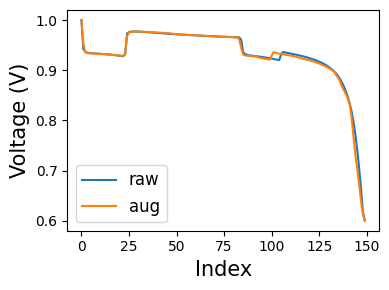

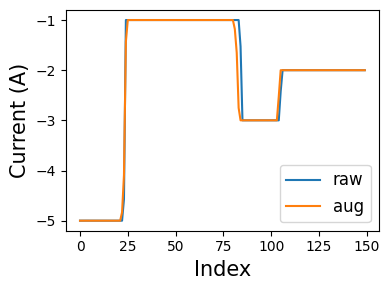

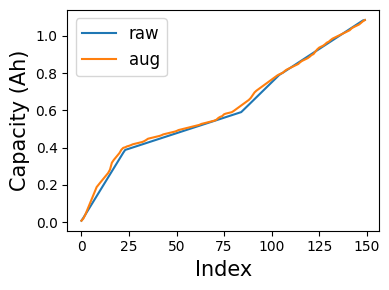

In [57]:
df = df.loc[df['current_in_A']<0]
voltages = df['voltage_in_V'].values
currents = df['current_in_A'].values
capacities = df['discharge_capacity_in_Ah'].values
voltages, currents, capacities = resample_charge_discharge_curves(voltages, currents, capacities)
fig = plt.figure(figsize=(4,3))
voltages = voltages / max(voltages)
plt.plot(np.arange(0,len(voltages)), voltages, label='raw')
X = torch.Tensor(voltages)
X = X.unsqueeze(0)
X = X.unsqueeze(-1)
# noise_voltages = gaussian_blur_1d(X, 11, 10)
# noise_voltages = add_gaussian_noise(X, 0.01)
noise_voltages = crop_aug(X, int(150*0.75))
noise_voltages = noise_voltages.squeeze(0).squeeze(-1).numpy()
plt.plot(np.arange(0,len(noise_voltages)), noise_voltages, label='aug')
print(noise_voltages.shape, voltages.shape)
plt.legend(fontsize=12)
plt.ylabel('Voltage (V)', fontsize=15)
plt.xlabel('Index', fontsize=15)

fig.tight_layout()
plt.show()

fig = plt.figure(figsize=(4,3))
currents = currents / 1.1
plt.plot(np.arange(0,len(currents)), currents, label='raw')
X = torch.Tensor(currents)
X = X.unsqueeze(0)
X = X.unsqueeze(-1)
noise_currents = crop_aug(X, int(150*0.75))
noise_currents = noise_currents.squeeze(0).squeeze(-1).numpy()
plt.plot(np.arange(0,len(noise_currents)), noise_currents, label='aug')
plt.legend(fontsize=12)
plt.ylabel('Current (A)', fontsize=15)
plt.xlabel('Index', fontsize=15)
fig.tight_layout()
plt.show()

fig = plt.figure(figsize=(4,3))
capacities = capacities / 1.1
plt.plot(np.arange(0,len(capacities)), capacities, label='raw')
X = torch.Tensor(capacities)
X = X.unsqueeze(0)
X = X.unsqueeze(-1)
noise_capacities = crop_aug(X, int(150*0.75))
noise_capacities = noise_capacities.squeeze(0).squeeze(-1).numpy()
plt.plot(np.arange(0,len(noise_capacities)), noise_capacities, label='aug')
plt.legend(fontsize=12)
plt.ylabel('Capacity (Ah)', fontsize=15)
plt.xlabel('Index', fontsize=15)
fig.tight_layout()
plt.show()



(112,) (150,)


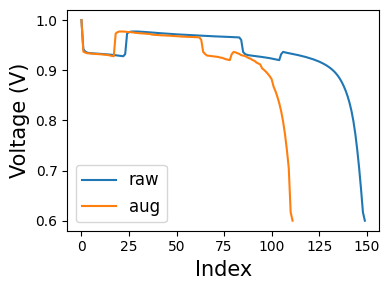

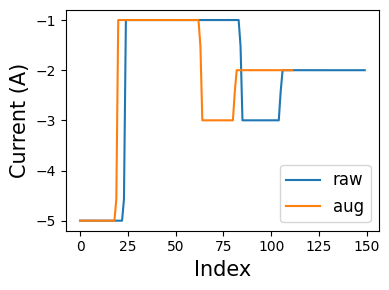

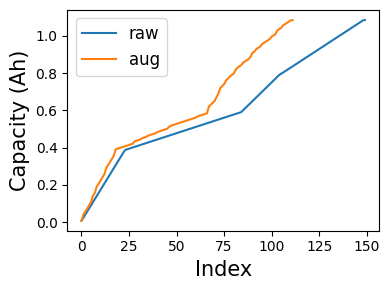

In [59]:
df = df.loc[df['current_in_A']<0]
voltages = df['voltage_in_V'].values
currents = df['current_in_A'].values
capacities = df['discharge_capacity_in_Ah'].values
voltages, currents, capacities = resample_charge_discharge_curves(voltages, currents, capacities)
fig = plt.figure(figsize=(4,3))
voltages = voltages / max(voltages)
plt.plot(np.arange(0,len(voltages)), voltages, label='raw')
X = torch.Tensor(voltages)
X = X.unsqueeze(0)
X = X.unsqueeze(-1)
# noise_voltages = gaussian_blur_1d(X, 11, 10)
# noise_voltages = add_gaussian_noise(X, 0.01)
noise_voltages = crop_aug(X, int(150*0.75))
noise_voltages = noise_voltages.squeeze(0).squeeze(-1).numpy()
plt.plot(np.arange(0,len(noise_voltages)), noise_voltages, label='aug')
print(noise_voltages.shape, voltages.shape)
plt.legend(fontsize=12)
plt.ylabel('Voltage (V)', fontsize=15)
plt.xlabel('Index', fontsize=15)

fig.tight_layout()
plt.show()

fig = plt.figure(figsize=(4,3))
currents = currents / 1.1
plt.plot(np.arange(0,len(currents)), currents, label='raw')
X = torch.Tensor(currents)
X = X.unsqueeze(0)
X = X.unsqueeze(-1)
noise_currents = crop_aug(X, int(150*0.75))
noise_currents = noise_currents.squeeze(0).squeeze(-1).numpy()
plt.plot(np.arange(0,len(noise_currents)), noise_currents, label='aug')
plt.legend(fontsize=12)
plt.ylabel('Current (A)', fontsize=15)
plt.xlabel('Index', fontsize=15)
fig.tight_layout()
plt.show()

fig = plt.figure(figsize=(4,3))
capacities = capacities / 1.1
plt.plot(np.arange(0,len(capacities)), capacities, label='raw')
X = torch.Tensor(capacities)
X = X.unsqueeze(0)
X = X.unsqueeze(-1)
noise_capacities = crop_aug(X, int(150*0.75))
noise_capacities = noise_capacities.squeeze(0).squeeze(-1).numpy()
plt.plot(np.arange(0,len(noise_capacities)), noise_capacities, label='aug')
plt.legend(fontsize=12)
plt.ylabel('Capacity (Ah)', fontsize=15)
plt.xlabel('Index', fontsize=15)
fig.tight_layout()
plt.show()

